# Plot filesystem workload tests

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
from collections import defaultdict
import sys
import yaml
import math
import glob
import os
import json
from tqdm.notebook import tqdm
from IPython.display import display,Image
from datetime import date
from ncar_branding import *

# Unit Conversions
kb2mb = 1000
kb2gb = 1000*kb2mb
kb2tb = 1000*kb2gb

In [2]:
times = defaultdict(list)
paths = set()
hosts = set()
fname2path = {}
dfs = {}

In [3]:
def load_metadata():
    alltimes = set()
    times.clear()
    dfs.clear() 
    
    for filename in tqdm(glob.glob('logs/*-GIT_CLONE.csv'), 
                         desc='Processing CSVs',
                         unit='file'): 
    
        dtype= {'Elapsed(s)'  : 'Int64',}
    
        #print(filename)
        host = None
        path = None
        with open(filename,'r') as f:
            for line in f:
                if '# ' in line:
                    line=line.strip().split()
                    #print(line[1], line[3])
                    host = line[1]
                    path = line[3]
                    break
    
        assert host
        assert path
        hosts.add(host)
        paths.add(path)
        fname2path[filename] = path
        
        #print(host, path)    
        
        df = pd.read_csv(filename,
                         skipinitialspace=True,
                         dtype=dtype,
                         comment='#',
                         parse_dates=['Date'],
                        )
        df.set_index('Date',inplace=True)
        
        times[path].extend(df['Elapsed(s)'].to_list())

        alltimes.update(set(df['Elapsed(s)'].to_list()))
            
    return (min(alltimes), max(alltimes)) 

In [4]:
def load_data(pattern):
    alltimes = set()
    times.clear()
    dfs.clear() 
    
    for filename in tqdm(glob.glob(pattern), 
                         desc='Processing CSVs',
                         unit='file'): 
    
        dtype= {'Elapsed(s)'  : 'Int64',}
    
        #print(filename)
        host = None
        path = None
        with open(filename,'r') as f:
            for line in f:
                if '# ' in line:
                    line=line.strip().split()
                    #print(line[1], line[3])
                    host = line[1]
                    path = line[3]
                    break
    
        assert host
        assert path
        hosts.add(host)
        paths.add(path)
        fname2path[filename] = path
        
        #print(host, path)    
        
        df = pd.read_csv(filename,
                         skipinitialspace=True,
                         dtype=dtype,
                         comment='#',
                         parse_dates=['Date'],
                        )
        df.set_index('Date',inplace=True)

        dfs[filename] = df
    
        alltimes.update(set(df['Elapsed(s)'].to_list()))
        
        times[path].extend(df['Elapsed(s)'].to_list())
        
        #fastest = np.max(fastest,df['Elapsed(s)'].max())
        #print(fastest)
        #display(df)
        #display(df.info(memory_usage=True))
    
        #print(pd.to_datetime(df.iloc[-1]))
        #break
    
    return (min(alltimes), max(alltimes)) 

In [5]:
def histogram(items,xlabel):
    
    fig, ax = plt.subplots(1, 1,
                           figsize=(12,6))
    format_ax(ax)
    
    
    bins = np.linspace(fastest, slowest, 11)
    #print(bins)
    
    ts = list()
    ls = list()
    
    for p in sorted(items):
        assert p in times
        t = times[p]
        ts.append(t)
        p = p.replace('/benkirk/fs_tests','')
        p = p.replace('/cisl/csg','')

        ls.append(p)
    
    ax.hist(ts, bins=bins,
            zorder=10,
            alpha=1,
            stacked=True,
            label=ls),
    
    ax.set_xlim(fastest, slowest)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count (#)')
    ax.legend(fancybox=True, loc=1)
    
    
    plt.show()
    fig.savefig('histogram.png', bbox_inches='tight', dpi=150, transparent=False)
    plt.close()
    return

In [6]:
def history(items,title,ylabel):

    selected = set(items)
    
    fig, ax = plt.subplots(1, 1,
                           figsize=(12,6))
    format_ax(ax)

    colors = {}

    for k in sorted(dfs.keys()):        
        df=dfs[k]
        #print(k)
        p = fname2path[k]
        if p not in items: continue
        p = p.replace('/benkirk/fs_tests','')
        p = p.replace('/cisl/csg','')
        #print(p)
        #print(df)
        for t in df.index:
            start = t
            duration = df.loc[t,'Elapsed(s)']
            end = start + pd.to_timedelta(duration, unit='seconds')
            #print(start,duration, end)
            l = ax.plot([start, end], 
                        [duration, duration], 
                        color=colors[p] if p in colors else None,
                        label=p if p not in colors else None,
                        linewidth=4)
            
            colors[p] = l[0].get_color()

    ax.set_ylim(0, slowest*1.05)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Date & Time')
    ax.legend(fancybox=True, loc=2)
    ax.tick_params(axis='x', labelrotation=60)
    
    plt.show()
    fig.savefig('history.png', bbox_inches='tight', dpi=150, transparent=False)
    plt.close()
    return

In [7]:
import ipywidgets as widgets
def selection(list=None,selected=None):
    if not selected:
        selected=list
    w = widgets.SelectMultiple(options=sorted(list),
                               value=selected,
                               rows=len(list),
                               description='CSVs',
                               layout={'width': 'initial'},
                               disabled=False)
    display(w)
    return w

In [8]:
load_metadata()
sel = selection(list(times.keys()),
                selected=[x for x in list(times.keys()) if 'foobar' not in x] )

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

SelectMultiple(description='CSVs', index=(1, 4, 0, 2, 3), layout=Layout(width='initial'), options=('/glade/cam…

## Test 1 - git clone times

In [9]:
fastest, slowest = load_data('logs/*-GIT_CLONE.csv')

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

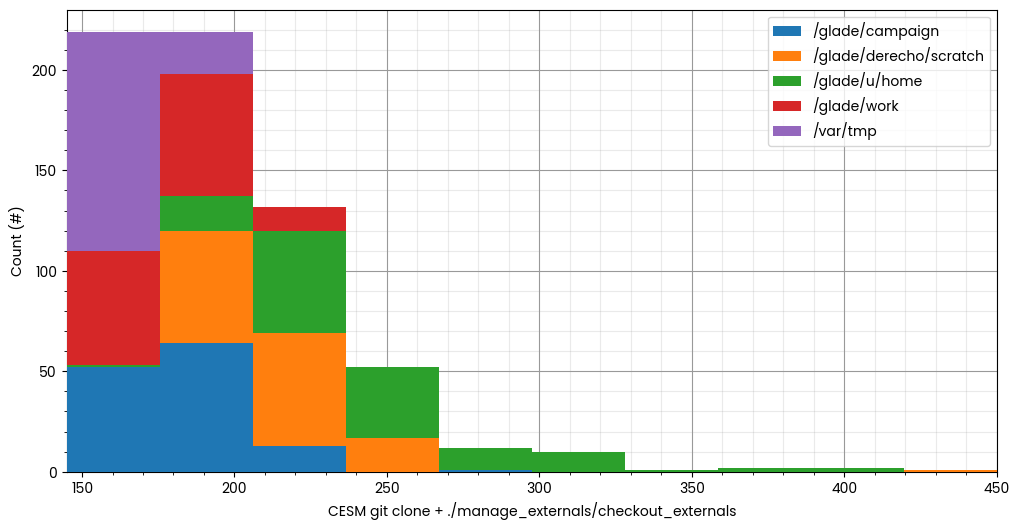

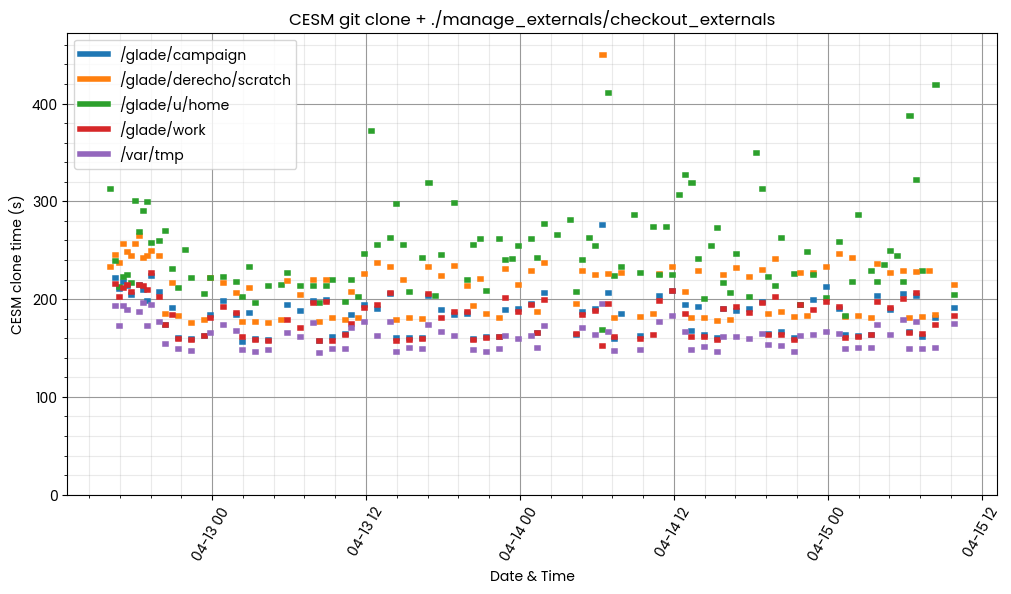

In [10]:
#print(sel.value)
label='CESM git clone + ./manage_externals/checkout_externals'
histogram(sel.value, xlabel=label)
history(sel.value, title=label, ylabel='CESM clone time (s)')

## Test 2 - `tar cv`

In [11]:
fastest, slowest = load_data('logs/*-TAR.csv')

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,
/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,
/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,


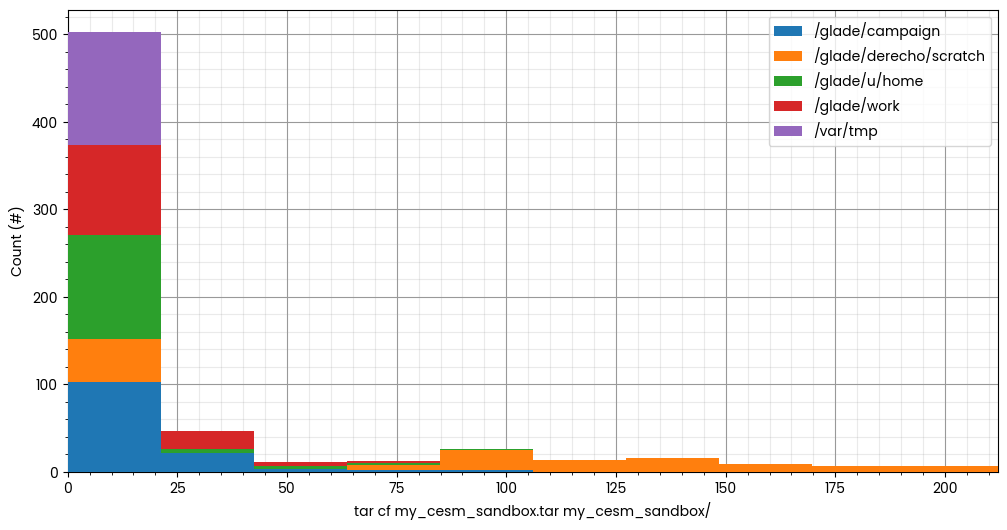

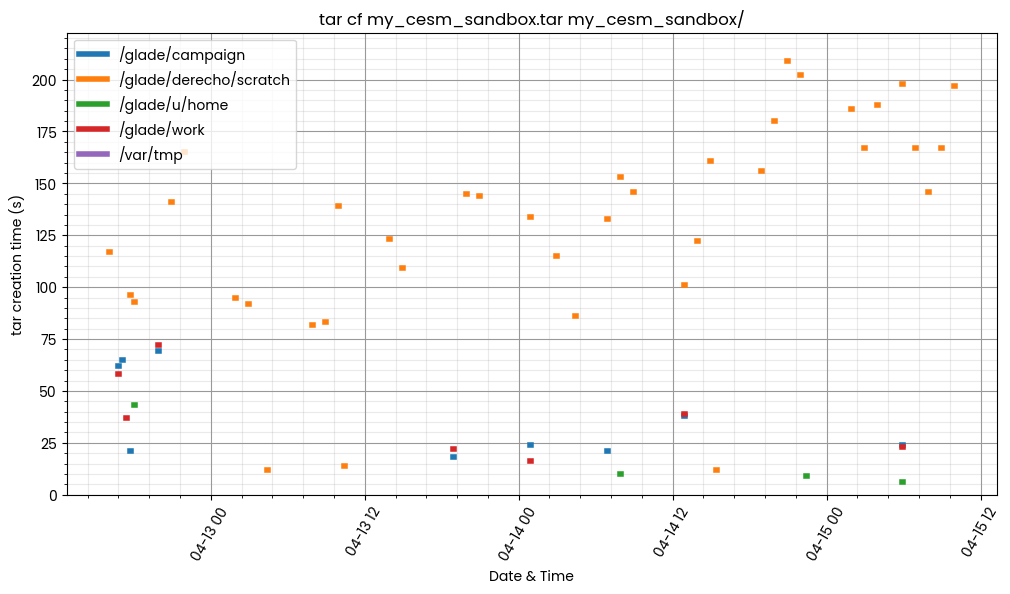

In [12]:
#print(sel.value)
label='tar cf my_cesm_sandbox.tar my_cesm_sandbox/'
histogram(sel.value, xlabel=label)
history(sel.value, title=label, ylabel='tar creation time (s)')

## Test 3 - `dd if=/dev/zero of=0.dat bs=1M count=24000`

In [13]:
fastest, slowest = load_data('logs/*-DD.csv')

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,


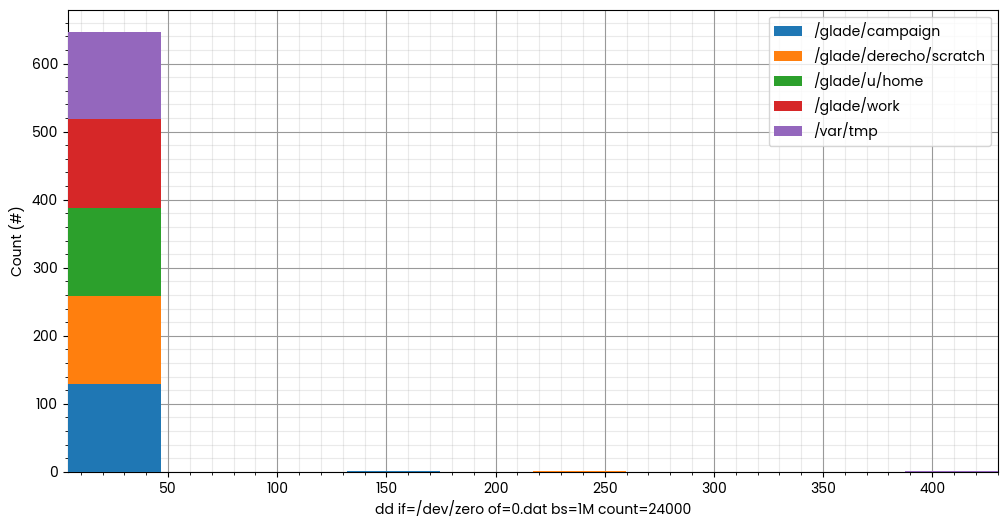

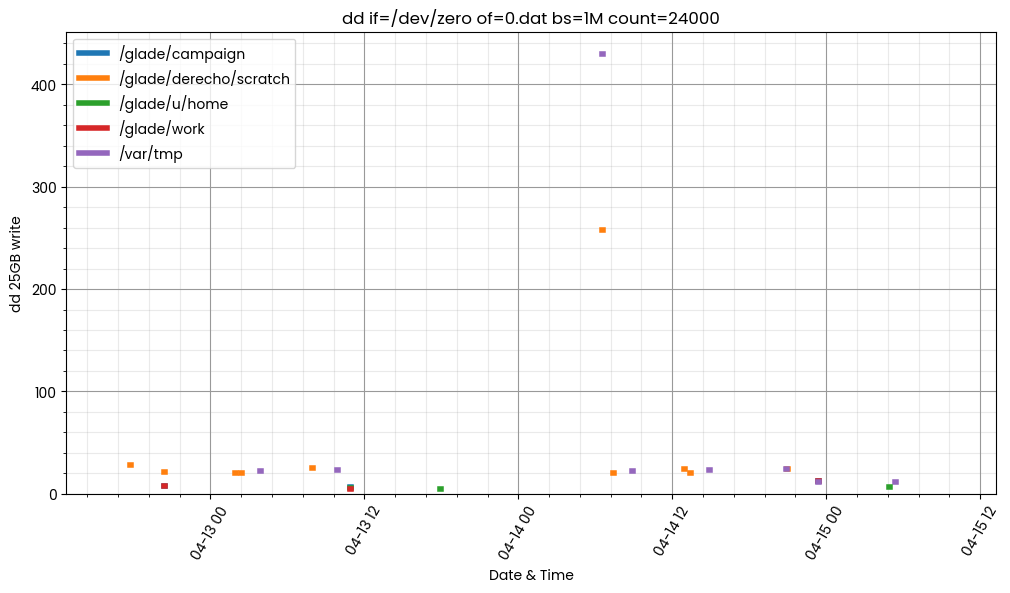

In [14]:
#print(sel.value)
label='dd if=/dev/zero of=0.dat bs=1M count=24000'
histogram(sel.value, xlabel=label)
history(sel.value, title=label, ylabel='dd 25GB write')

## Test 4 - `rsync` (single file system)

In [15]:
fastest, slowest = load_data('logs/*-RSYNC.csv')

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,


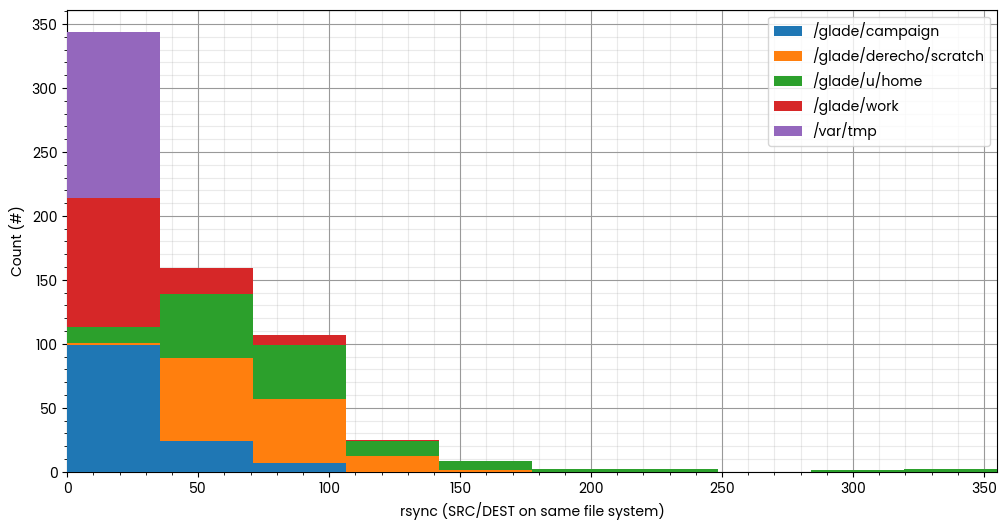

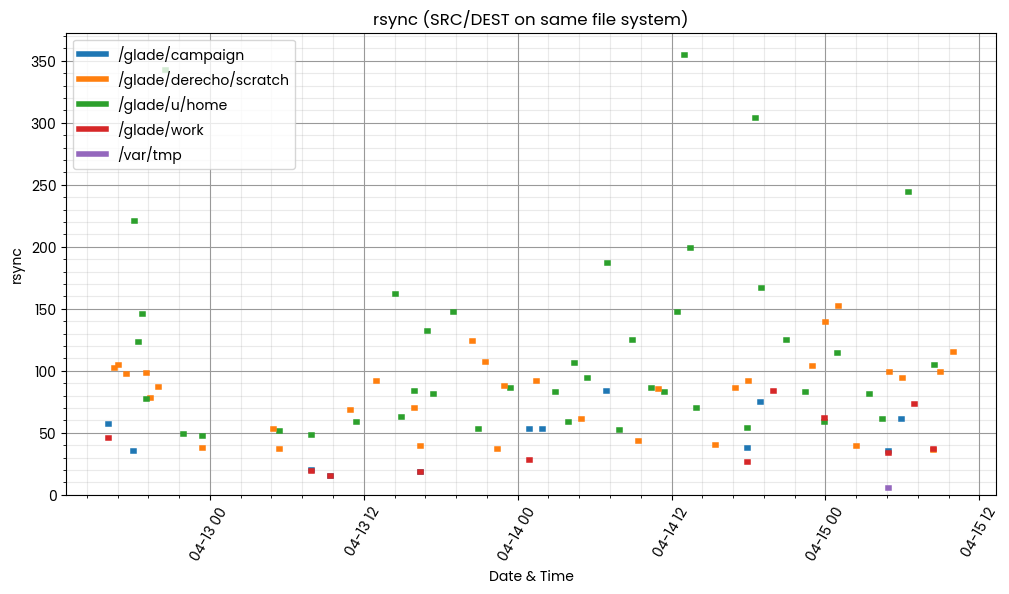

In [16]:
#print(sel.value)
label='rsync (SRC/DEST on same file system)'
histogram(sel.value, xlabel=label)
history(sel.value, title=label, ylabel='rsync')

## Test 6 - cleanup

In [17]:
fastest, slowest = load_data('logs/*-CLEANUP.csv')

Processing CSVs:   0%|          | 0/10 [00:00<?, ?file/s]

/glade/derecho/scratch/benkirk/tmp/ipykernel_5847/3856099023.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(filename,


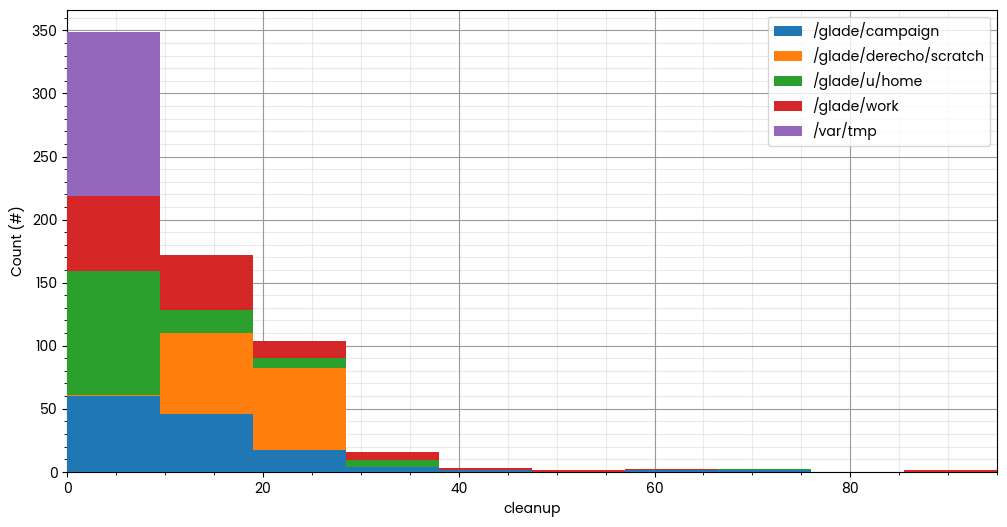

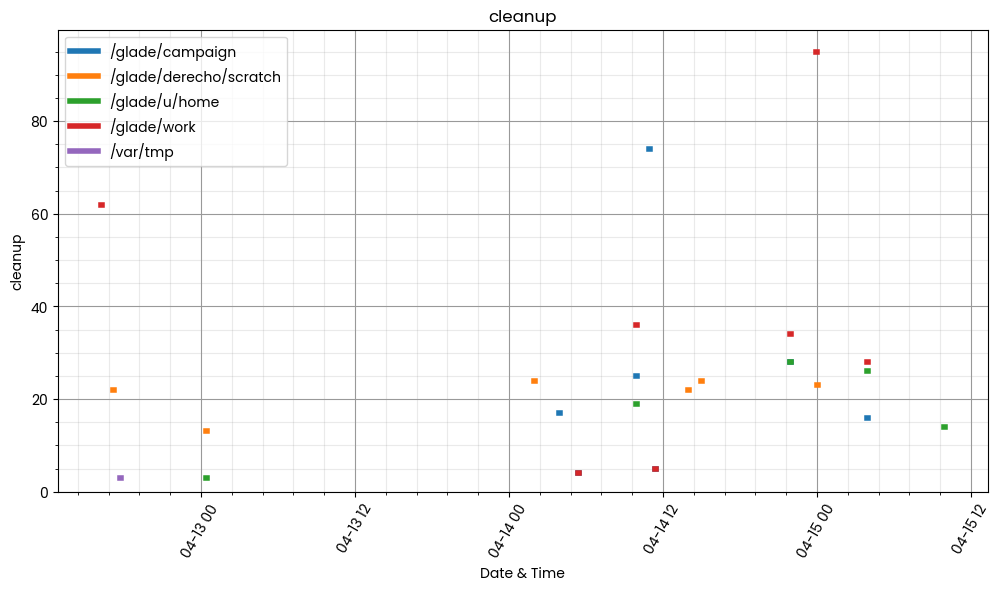

In [18]:
#print(sel.value)
label='cleanup'
histogram(sel.value, xlabel=label)
history(sel.value, title=label, ylabel='cleanup')